In [1]:
from polartoolkit import fetch, maps, profiles, regions, utils
#import polartoolkit as ptk
import verde as vd
import invert4geom
import numpy as np
import pandas as pd
import harmonica
import matplotlib.pyplot as plt

import xarray as xr

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

region = regions.getz_ice_shelf

In [4]:
Data = pd.read_csv('constraint_points.csv')
#Data = Data[:10000]
constraint_points = Data[0::1] #uses every 10th datapoint
constraint_points

,easting,northing,bed_elevation
0,-1.559078e+06,-1.233548e+06,-3538.024543
1,-1.558187e+06,-1.233347e+06,-3531.229456
2,-1.556044e+06,-1.233857e+06,-3514.162884
3,-1.555333e+06,-1.233868e+06,-3512.433386
4,-1.554346e+06,-1.233878e+06,-3512.510757
...,...,...,...
55498,-1.154000e+06,-6.640000e+05,-957.328003
55499,-1.152750e+06,-6.645000e+05,-961.495514
55500,-1.147000e+06,-6.640000e+05,-362.992767
55501,-1.136500e+06,-6.645000e+05,-96.594223


In [5]:

# block median with 1km blocks
reducer = vd.BlockReduce(reduction=np.median, spacing=2e3)
coordinates, data = reducer.filter(
    (constraint_points.easting, constraint_points.northing),
    constraint_points.bed_elevation
)

constraint_points = pd.DataFrame({"easting": coordinates[0], "northing": coordinates[1],"bed_elevation":data})
constraint_points

,easting,northing,bed_elevation
0,-1.622250e+06,-1.232500e+06,-3468.870361
1,-1.620500e+06,-1.232000e+06,-3450.757813
2,-1.618950e+06,-1.232610e+06,-3437.388793
3,-1.561311e+06,-1.232571e+06,-3592.147094
4,-1.558983e+06,-1.232532e+06,-3560.519273
...,...,...,...
20150,-1.152750e+06,-6.645000e+05,-957.328003
20151,-1.148000e+06,-6.650000e+05,-256.898041
20152,-1.147000e+06,-6.640000e+05,-362.992767
20153,-1.136250e+06,-6.650000e+05,-129.547539


In [6]:
spline = vd.Spline(damping=0.001)



spline.fit(coordinates=(constraint_points.easting, constraint_points.northing), data=constraint_points['bed_elevation'])

,mindist,0
,damping,0.001
,force_coords,None
,engine,'auto'


In [7]:
grid = spline.grid(region= region, spacing = 2000, data_names = 'upward')

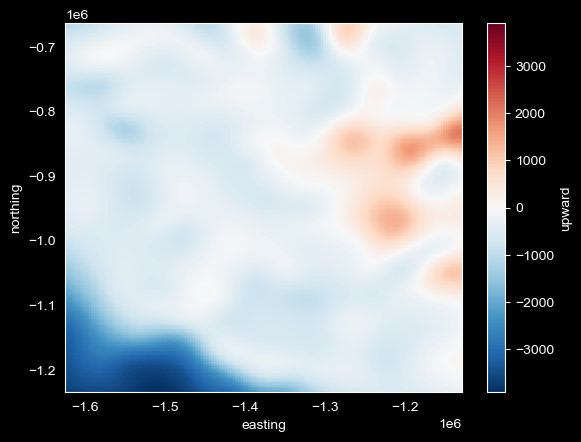

In [8]:
grid.upward.plot()# get bedmap3 bed topography grid


In [9]:
# get bedmap3 bed topography grid
bed_topography = fetch.bedmap3(layer="bed", region = region, reference="ellipsoid")


requested spacing (500.0) is smaller than the original (1000.0).


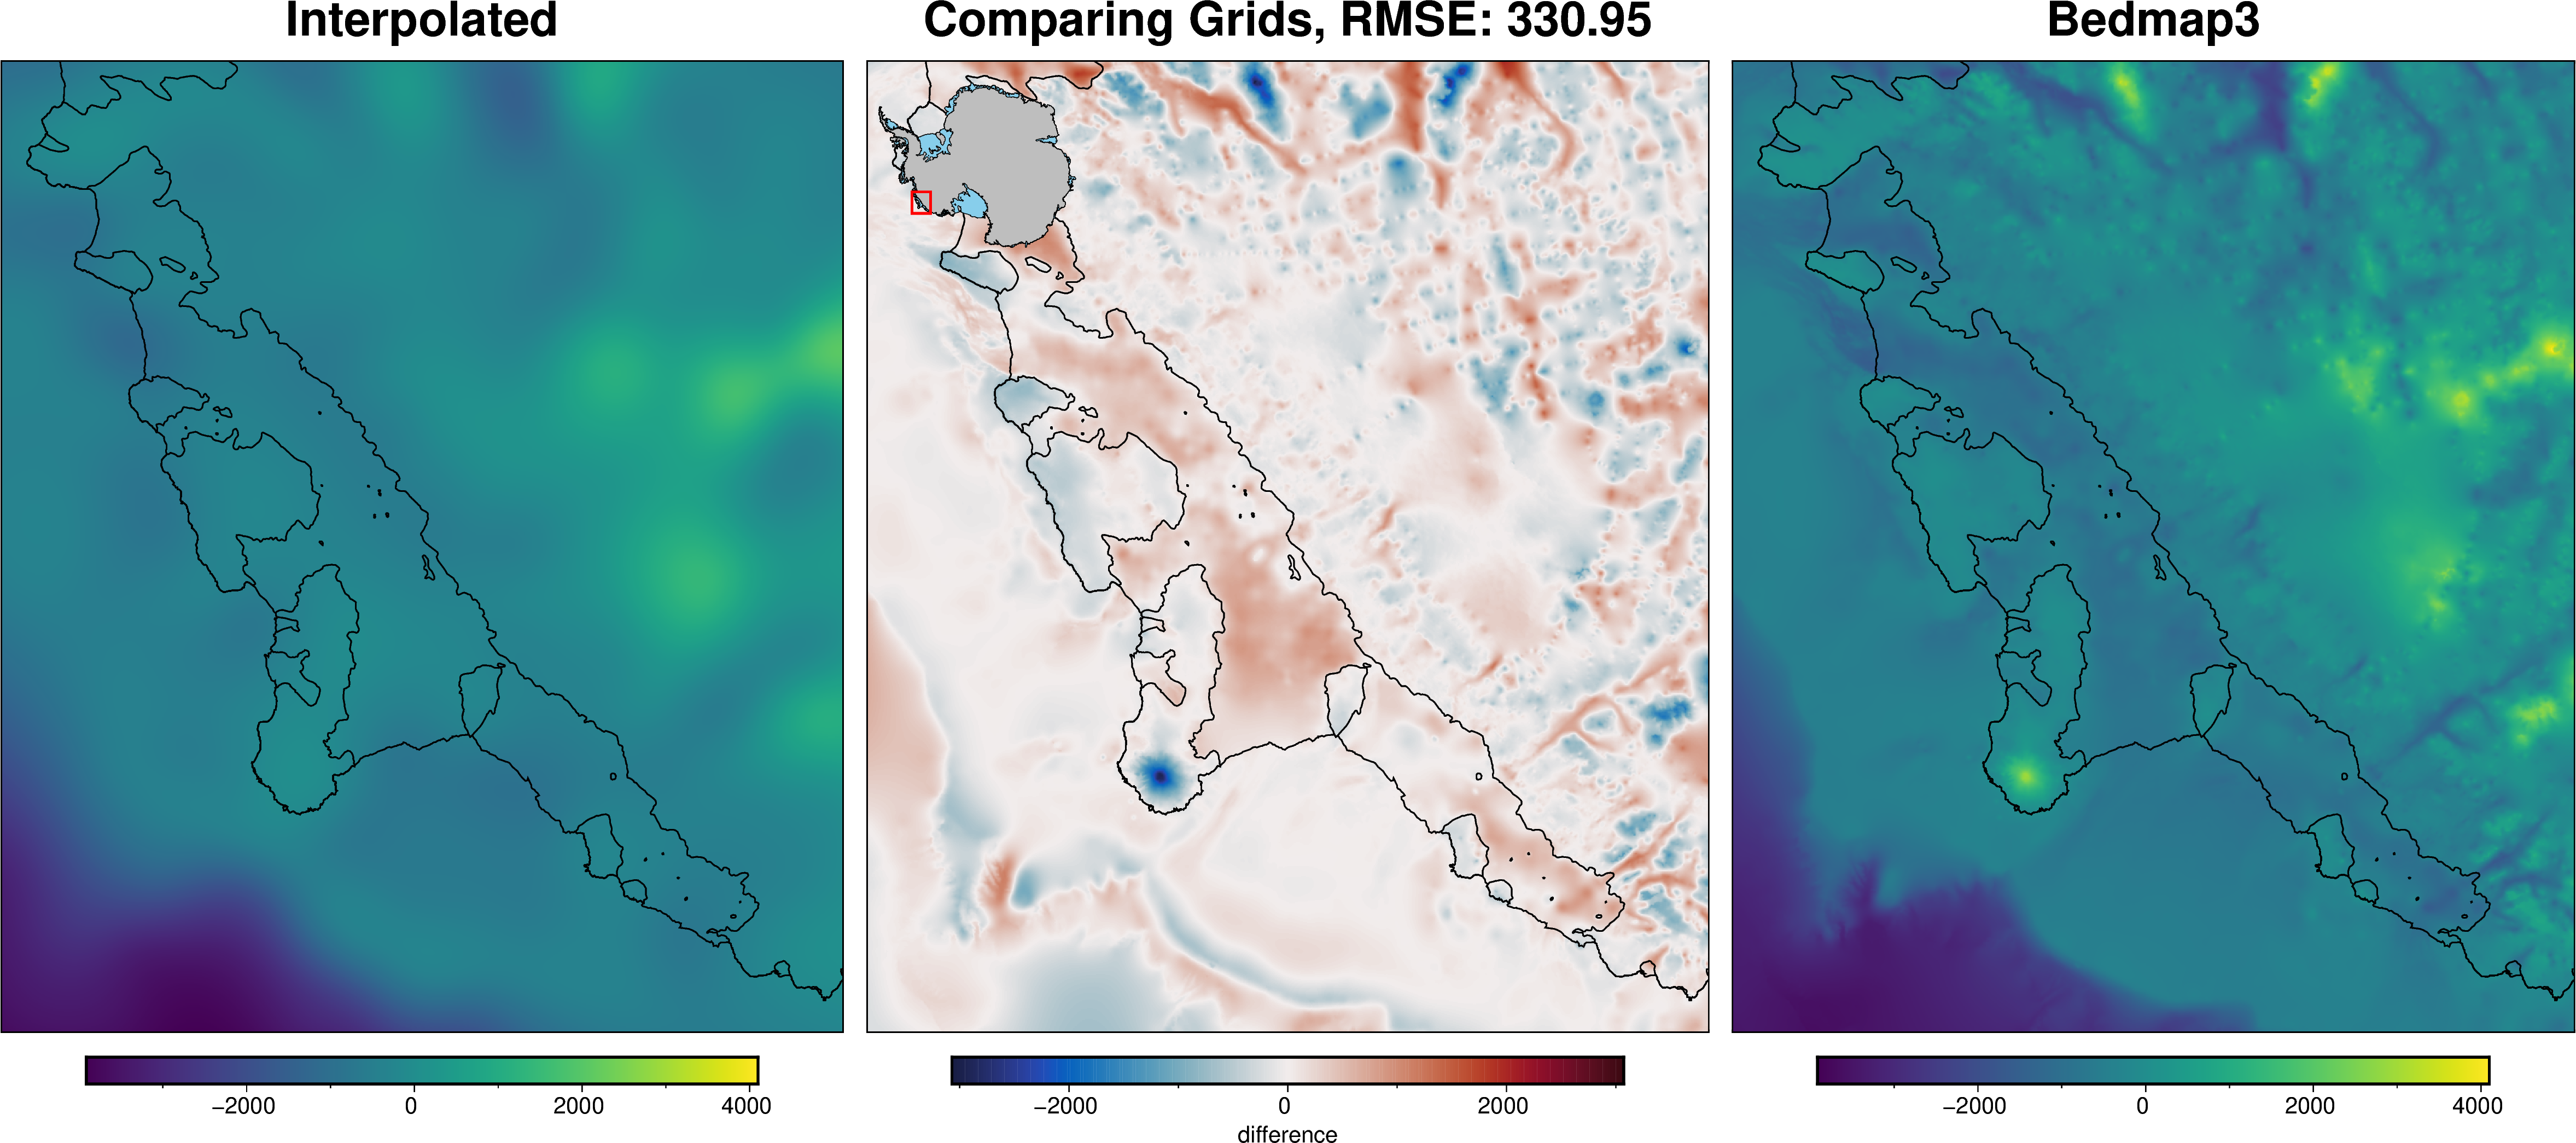

In [10]:
_=utils.grd_compare(grid.upward, bed_topography, coast = True, 
                   grid1_name = 'Interpolated',
                    grid2_name = 'Bedmap3'
                   )

# Mask with xarray

In [12]:
Ice_base = fetch.bedmap3(layer="icebase", region = region, reference="ellipsoid")

Ice_base = Ice_base.rename({"x":"easting", "y":"northing"})

requested spacing (500.0) is smaller than the original (1000.0).


In [13]:
interpolated_bed = grid.upward.where(grid.upward <= Ice_base, Ice_base)


AlignmentError: cannot align objects with join='exact' where index/labels/sizes are not equal along these coordinates (dimensions): 'easting' ('easting',)

In [ ]:
interpolated_bed.plot()

In [ ]:
(grid.upwards - interpolated_bed).plot()

In [ ]:
interpolated_bed.to_netcdf('interpolated_bed.nc')